# この課題の目的

- スクラッチを通してCNNの基礎を理解する

# スクラッチによる実装

NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。

Sprint11で作成したディープニューラルネットワークのクラスを拡張する形でCNNを作成します。まず、Sprint12で1次元畳み込み層を作成し、畳み込みの基礎を理解することを目指します。そして、Sprint13で一般的に画像に対して使われる2次元畳み込み層とプーリング層を作成します。

## 1次元畳み込み層

畳み込みニューラルネットワークは画像に対して使われる2次元畳み込みが代表的ですが、理解を容易にするためにまずは1次元畳み込みを実装します。1次元畳み込みは系列データで使われることが多いです。畳み込みは任意の次元に対して考えることができ、立体データに対しての3次元畳み込みまでがフレームワークで一般的に用意されています。

## データセットの用意

引き続きMNISTデータセットを使用します。1次元畳み込みでは全結合のニューラルネットワークと同様に平滑化されたものを入力します。

In [1]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import OrderedDict
import copy

Using TensorFlow backend.


In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
X_train = X_train.reshape(-1, 1, 784)
X_test = X_test.reshape(-1, 1, 784)

In [4]:
X_train.shape

(60000, 1, 784)

In [5]:
X_train = X_train[:4800]
y_train = y_train[:4800]
X_test = X_test[:1200]
y_test = y_test[:1200]

In [6]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape) 
print(X_val.shape)

(3840, 1, 784)
(960, 1, 784)


## CNN分類器クラスの作成
1次元畳み込みニューラルネットワークモデルのクラスScratch1dCNNClassifierを作成してください。Sprint11で作成したScratchDeepNeuralNetrowkClassifierを元にしてください。

# 【問題1】チャンネル数を1に限定した1次元畳み込み層クラスの作成

チャンネル数を1に限定した1次元畳み込み層のクラスSimpleConv1dを作成してください。基本構造はsprint11で作成したFCクラスと同じになります。なお、重みの初期化に関するクラスは必要に応じて作り変えてください。Xavierの初期値などを使う点は全結合層と同様です。

ここではパディングは考えず、ストライドも1に固定します。また、複数のデータを同時に処理することも考えなくて良く、バッチサイズは1のみに対応してください。この部分の拡張はアドバンス課題とします。

フォワードプロパゲーションの数式は以下のようになります。

$$
a_i = \sum_{s=0}^{F-1}x_{(i+s)}w_s+b
$$

$a_i$  : 出力される配列のi番目の値

$F$ : フィルタのサイズ

$x_{(i+s)}$ : 入力の配列の(i+s)番目の値

$w_s$ : 重みの配列のs番目の値

$b$ : バイアス項

全てスカラーです。

次に更新式です。ここがAdaGradなどに置き換えられる点は全結合層と同様です。

$$
w_s^{\prime} = w_s - \alpha \frac{\partial L}{\partial w_s}
$$

$$
b^{\prime} = b - \alpha \frac{\partial L}{\partial b}
$$

$\alpha$  : 学習率

$\frac{\partial L}{\partial w_s}$ : $w_s$ に関する損失 $L$ の勾配

$\frac{\partial L}{\partial b}$ : $b$ に関する損失 $L$ の勾配

勾配$\frac{\partial L}{\partial w_s}$ や $\frac{\partial L}{\partial b}$ を求めるためのバックプロパゲーションの数式が以下です。

$$
\frac{\partial L}{\partial w_s} = \sum_{i=0}^{N_{out}-1} \frac{\partial L}{\partial a_i}x_{(i+s)}
$$

$$
\frac{\partial L}{\partial b} = \sum_{i=0}^{N_{out}-1} \frac{\partial L}{\partial a_i}
$$

$\frac{\partial L}{\partial a_i}$ : 勾配の配列のi番目の値

$N_{out}$ : 出力のサイズ

前の層に流す誤差の数式は以下です。

$$
\frac{\partial L}{\partial x_j} = \sum_{s=0}^{F-1} \frac{\partial L}{\partial a_{(j-s)}}w_s
$$

$\frac{\partial L}{\partial x_j}$ : 前の層に流す誤差の配列のj番目の値

ただし、$j-s<0$または$j-s>N_{out}-1$のとき$\frac{\partial L}{\partial a_{(j-s)}} =0$です。

全結合層との大きな違いは、重みが複数の特徴量に対して共有されていることです。この場合は共有されている分の誤差を全て足すことで勾配を求めます。計算グラフ上での分岐はバックプロパゲーションの際に誤差の足し算をすれば良いことになります。

## SimpleConv1dクラス

In [8]:
class SimpleConv1d:
    """
    チャンネル数を1の時の1次元畳み込み演算を行う
    Parameters
    ----------
    hidden_size_previous : int
      前の層のノード数
    hidden_size : int
      後の層のノード数
    filter_size : int
    　フィルタサイズ
    initializer : インスタンス
    　初期化方法のインスタンス
    optimizer : インスタンス
    　最適化手法のインスタンス
     
    Attributes
    ----------
    W : numpy配列
    　フィルタ
    B : numpy配列
    　バイアス
    dif_W : numpy配列
    　Wの微分
    dif_B : numpy配列
    　Bの微分
    forward_input : numpy配列
    　順伝搬の入力
    index : numpy配列
      順伝搬時に使用するindexを格納した配列
    """

    def __init__(self, hidden_size_previous, hidden_size, filter_size, initializer, optimizer):
        self.hidden_size_previous = hidden_size_previous
        self.hidden_size = hidden_size
        self.initializer = initializer
        self.optimizer = optimizer

        self.W = initializer.W(layer)
        self.B = initializer.B(layer)
        self.dif_W = None
        self.dif_B = None
        
        self.forward_input = None
        self.index = None
        
    
    def forward(self, forward_input):
        """
        フォワードプロバケーション
        Parameters
        ----------
        forward_input : numpy配列
            順伝搬の入力
            
        Returns
        ----------
        forward_output : numpy配列
            順伝搬の出力
        """
        #Xをコピー
        self.forward_input = forward_input.copy()
        
        #配列作成
        self.index = np.arange(self.W.shape[0]) + np.arange(self.W.shape[0] - 1).reshape(-1, 1)

        #出力の計算
        forward_output = forward_input[self.index] @ self.W.T + self.B

        return forward_output
    
    
    def backward(self, backward_input):
        """
        バックプロバケーション
        Parameters
        ----------
        backward_input : numpy配列
            逆伝搬の入力
            
        Returns
        ----------
        backward_output : numpy配列
            逆伝搬の出力
        """
        self.dif_B = np.sum(backward_input)
        
        self.dif_W = np.dot(backward_input, self.forward_input[self.index])
        
        backward_output = np.zeros(self.forward_input.shape[0])
        
        output_size = self.compute_output_size_1d(self.forward_input.shape[0], 0, self.W.shape[0], 1)
                
        for j in range(self.forward_input.shape[0]):
            for s in range(self.W.shape[0]):

                if (j - s < 0) or (j - s > output_size - 1):
                     backward_output[j] += 0 * self.W[s]
                else:
                    backward_output[j] += backward_input[j - s] * self.W[s]
        
        # 重み、バイアスの更新
        self = self.optimizer.update(self)
        return backward_output
    
    
    def compute_output_size_1d(self, input_size,　filter_size, pad,  stride):
        '''
        出力サイズの計算
        
        Parameters
        --------------
        input_size : int
            入力のサイズ
        filter_size : 
            フィルター(重み)のサイズ
        pad : int
            パディング数
        stride : 
            ストライドのサイズ
            
        returns
        ---------
        output_size : int
            出力のサイズ
        '''
        output_size = int((input_size + 2 * pad - filter_size) / stride ) + 1
        
        return output_size

## 【問題2】1次元畳み込み後の出力サイズの計算

畳み込みを行うと特徴量の数が変化します。どのように変化するかは以下の数式から求められます。パディングやストライドも含めています。この計算を行う関数を作成してください。

$$
N_{out} =  \frac{N_{in}+2P-F}{S} + 1
$$

$N_{out}$ : 出力のサイズ（特徴量の数）

$N_{in}$ : 入力のサイズ（特徴量の数）

$P$ : ある方向へのパディングの数

$F$ : フィルタのサイズ

$S$ : ストライドのサイズ

In [9]:
def compute_output_size_1d(input_size,　filter_size, stride, pad):
        '''
        出力サイズの計算
        
        Parameters
        --------------
        input_size : int
            入力のサイズ
        filter_size : 
            フィルター(重み)のサイズ
        stride : 
            ストライドのサイズ
        pad : int
            パディング数
  
        returns
        ---------
        output_size : int
            出力のサイズ
        '''
    compute_output_size_1d = int(((input_size + 2 * pad - filter_size) / stride ) + 1)
    return compute_output_size_1d

# 【問題3】小さな配列での1次元畳み込み層の実験

次に示す小さな配列でフォワードプロパゲーションとバックプロパゲーションが正しく行えているか確認してください。

入力x、重みw、バイアスbを次のようにします。

In [ ]:
# x = np.array([1,2,3,4])  
# w = np.array([3, 5, 7])  
# b = np.array([1]) 

フォワードプロパゲーションをすると出力は次のようになります。

In [ ]:
# a = np.array([35, 50])

次にバックプロパゲーションを考えます。誤差は次のようであったとします。

In [ ]:
# delta_a = np.array([10, 20])

バックプロパゲーションをすると次のような値になります。

In [ ]:
# delta_b = np.array([30])  
# delta_w = np.array([50, 80, 110])  
# delta_x = np.array([30, 110, 170, 140])

## 実装上の工夫

畳み込みを実装する場合は、まずはfor文を重ねていく形で構いません。しかし、できるだけ計算は効率化させたいため、以下の式を一度に計算する方法を考えることにします。

$$
a_i = \sum_{s=0}^{F-1}x_{(i+s)}w_s+b
$$

バイアス項は単純な足し算のため、重みの部分を見ます。

$$
\sum_{s=0}^{F-1}x_{(i+s)}w_s
$$

これは、xの一部を取り出した配列とwの配列の内積です。具体的な状況を考えると、以下のようなコードで計算できます。この例では流れを分かりやすくするために、各要素同士でアダマール積を計算してから合計を計算しています。これは結果的に内積と同様です。

In [ ]:
# x = np.array([1, 2, 3, 4])
# w = np.array([3, 5, 7])
# a = np.empty((2, 3))

# indexes0 = np.array([0, 1, 2]).astype(np.int)
# indexes1 = np.array([1, 2, 3]).astype(np.int)

# a[0] = x[indexes0]*w # x[indexes0]は([1, 2, 3])である
# a[1] = x[indexes1]*w # x[indexes1]は([2, 3, 4])である

# a = a.sum(axis=1)

ndarrayは配列を使ったインデックス指定ができることを利用した方法です。

また、二次元配列を使えば一次元配列から二次元配列が取り出せます。


In [ ]:
# x = np.array([1, 2, 3, 4])
# indexes = np.array([[0, 1, 2], [1, 2, 3]]).astype(np.int)

# print(x[indexes]) # ([[1, 2, 3], [2, 3, 4]])

このこととブロードキャストなどをうまく組み合わせることで、一度にまとめて計算することも可能です。

畳み込みの計算方法に正解はないので、自分なりに効率化していってください。

## 参考

以下のページのInteger array indexingの部分がこの方法についての記述です。

[Indexing — NumPy v1.15 Manual](https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html)

## ①順伝搬

In [10]:
#フォワードプロバケーションの初期値
x = np.array([1,2,3,4])
w = np.array([3, 5, 7])
b = np.array([1])

### 畳み込み演算を行うindexを作成

In [11]:
#配列作成
index1 = np.arange(w.shape[0])
index1

array([0, 1, 2])

In [12]:
index2 = np.arange(w.shape[0] - 1).reshape(-1, 1)
index2

array([[0],
       [1]])

In [13]:
index3 = index1 + index2
index3

array([[0, 1, 2],
       [1, 2, 3]])

In [14]:
x[index3]

array([[1, 2, 3],
       [2, 3, 4]])

### 畳み込み演算を実施

In [15]:
w[:, np.newaxis]

array([[3],
       [5],
       [7]])

In [16]:
x[index3] @ w[:, np.newaxis]

array([[34],
       [49]])

In [17]:
x[index3] @ w[:, np.newaxis] + b

array([[35],
       [50]])

## ②逆伝搬

In [18]:
#バックプロバケーションの初期値
delta_a = np.array([10, 20])

In [19]:
delta_b = np.sum(delta_a)
delta_b

30

In [20]:
delta_w = np.dot(delta_a, x[index3])
delta_w

array([ 50,  80, 110])

In [21]:
#0配列を用意
dx = np.zeros(x.shape[0])

#計算
for j in range(x.shape[0]):
    for s in range(w.shape[0]):
        
        #場合分け
        if j - s < 0 or j - s > 1:
             dx[j] += 0 * w[s]
        else:
            dx[j] += delta_a[j - s] * w[s]

dx

array([ 30., 110., 170., 140.])

# 【問題4】チャンネル数を限定しない1次元畳み込み層クラスの作成

チャンネル数を1に限定しない1次元畳み込み層のクラスConv1dを作成してください。

紙やホワイトボードを使い計算グラフを書きながら考えてください。

例えば以下のようなx, w, bがあった場合は、

In [ ]:
# x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]]) # shape(2, 4)で、（入力チャンネル数、特徴量数）である。  
# w = np.ones((3, 2, 3)) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)である。  
# b = np.array([1, 2, 3]) # （出力チャンネル数）

出力は次のようになります。

In [ ]:
# a = np.array([[16, 22], [17, 23], [18, 24]]) # shape(3, 2)で、（出力チャンネル数、特徴量数）である。

入力が2チャンネル、出力が3チャンネルの例です。計算グラフを書いた上で、バックプロパゲーションも手計算で考えてみましょう。計算グラフの中には和と積しか登場しないので、微分を新たに考える必要はありません。
## 補足

チャンネル数を加える場合、配列をどういう順番にするかという問題があります。(バッチサイズ、チャンネル数、特徴量数)または(バッチサイズ、特徴量数、チャンネル数)が一般的で、ライブラリによって順番は異なっています。（切り替えて使用できるものもあります）

今回のスクラッチでは自身の実装上どちらが効率的かを考えて選んでください。上記の例ではバッチサイズは考えておらず、(チャンネル数、特徴量数)です。

In [24]:
class Conv1d:
    """
    チャンネル数を指定しない1次元畳み込み層クラス
    Parameters
    ----------
    filter_num : int
      フィルタの数
    channel_num : int
      フィルタのチャンネル数
    filter_size : int
      フィルタサイズ
    initializer : インスタンス
        初期化方法のインスタンス
    optimizer : インスタンス
        最適化手法のインスタンス
    stride : int
        ストライド
    pad : int
         パディング
         
    Attributes
    ----------
    W : numpy配列
        重み
    B : numpy配列
        バイアス
    forward_input : numpy配列 
        順伝搬の入力
    out_w : numpy配列
        順伝搬時に使用する配列
    """
        
    def __init__(self, filter_num, channel_num, filter_size, initializer, optimizer, stride, pad):
        self.filter_num = filter_num
        self.channel_num = channel_num
        self.filter_size = filter_size
        self.initializer = initializer
        self.optimizer = optimizer
        self.stride = stride
        self.pad = pad
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = self.initializer.W(self)
        self.B = self.initializer.B(self)
        
        #インスタンス変数
        self.forward_input = None
        self.out_w = None


    
    def forward(self, forward_input):
        """
        フォワードプロバケーション
        Parameters
        ----------
        forward_input : 入力
            
        Returns
        ----------
        forward_output : 出力
        """
        self.forward_input = forward_input
        
        batch, C, W = self.forward_input.shape
        
        FN, C, FS = self.W.shape

        self.out_w = self.compute_output_size_1d(W, self.pad, FS, self.stride)

        forward_output = np.zeros((batch, FN, self.out_w)) #(バッチサイズ, 出力チャンネル数, 特徴量数)

        #バッチ
        for i in range(batch):
            #出力チャンネル
            for j in range(FN):
                #入力チャンネル
                for k in range(C):
                    #特徴量数
                    for l in range(self.out_w):
                        forward_output[i, j, l] += np.sum(self.forward_input[i, k, l: l + FS] * self.W[j, k, :] ) 

        forward_output += self.B.reshape(1, -1, 1)
        
        return forward_output

    
    def backward(self, backward_input):
        """
        バックプロバケーション
        Parameters
        ----------
        backward_input : numpy配列
            逆伝搬の入力
            
        Returns
        ----------
        backward_output : numpy配列
            逆伝搬の出力
        """
        FN, FC, FS = self.W.shape
        batch, C, W = self.forward_input.shape

        self.dif_W = np.zeros(self.W.shape)
        backward_output = np.zeros(self.forward_input.shape)

        for i in range(batch):
            for j in range(FN):
                for k in range(FC):
                    for l in range(FS):
                        for m in range(self.out_w):
                            self.dif_W[j, k, l] += backward_input[i, j, m] * self.forward_input[i, k, l + m]
                            backward_output[i, k, l + m] += backward_input[i, j, m] * self.W[j, k, l]

        self.dif_B = backward_input.sum(axis=2)
        
        # 重み、バイアスの更新
        self = self.optimizer.update(self)
        
        return backward_output

    
    def compute_output_size_1d(self, input_size, filter_size, stride, pad):
        '''
        出力サイズの計算
        
        Parameters
        --------------
        input_size : int
            入力のサイズ
        filter_size : 
            フィルター(重み)のサイズ
        stride : 
            ストライドのサイズ
        pad : int
            パディング数
            
        returns
        ---------
        compute_output_size_1d_size : int
            出力のサイズ
        '''
        compute_output_size_1d = int((input_size + 2 * pad - filter_size) / stride ) + 1
        
        return compute_output_size_1d

## 【問題5】学習・推定

これまで使ってきたニューラルネットワークの全結合層の一部をConv1dに置き換えて学習と推定を行ってください。出力層だけは全結合層をそのまま使ってください。

チャンネルが複数ある状態では全結合層への入力は行えません。その段階でのチャンネルは1になるようにするか、平滑化を行います。平滑化はNumPyのreshapeが使用できます。

[numpy.reshape — NumPy v1.15 Manual](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.reshape.html)

画像に対しての1次元畳み込みは実用上は行わないことのため、精度は問いません。

## ScratchConv1DNeuralNetrowkClassifierクラス

In [25]:
class ScratchConv1DNeuralNetrowkClassifier():
    
    """
    シンプルなCNN分類器

    Parameters
    ----------
    lr :　float
        学習率
    sigma　：　float
        ガウス分布の標準偏差
    batch_size : int
        バッチサイズ
    n_epochs : int
        エポック数
    conv_params : タプル
        Conv層の情報
    hidden_size : int
        隠れ層の数
    n_output : int
        出力のクラス数（3層目のノード数）
    initilizer : インスタンス
        初期化方法のクラスのインスタンス
    activater : インスタンス
        活性化関数のクラスのインスタンス
    optimizer : インスタンス
        最適化方法のインスタンス
    verbose : bool
        学習結果を表示するかを設定するフラグ
    
    Attributes
    ----------
    filter_channel : int
        フィルターのチャンネル数
    filter_num : int
        フィルターの数
    filter_size : int
        フィルターのサイズ
    stride : int
        ストライド
    pad : int
        パディング
        
    hidden_size : int
        隠れ層の数
    n_output : int
        出力サイズ
        
    self.loss_list : list
        エポック毎の学習用データに対するロスを格納しているリスト
    self.val_loss_list : list
        エポック毎の検証用データに対するロスを格納しているリスト
    self.verification_flag : bool
        検証用データの有無を設定するフラグ
    self.layers : OrderdDict
        各層のインスタンスを格納する辞書
    """

    def __init__(self,lr, sigma, batch_size, n_epochs, conv_params,\
                 hidden_size, n_output, initializer, activater, optimizer, verbose=None):

        self.lr = lr
        self.sigma = sigma
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        
        self.filter_channel = conv_params['filter_channel']
        self.filter_num = conv_params['filter_num']
        self.filter_size = conv_params['filter_size']
        self.stride = conv_params['stride']
        self.pad = conv_params['pad']
        
        self.hidden_size = hidden_size
        self.n_output = n_output
        
        self.verbose = verbose
        
        # 損失を記録する配列を用意
        self.loss_list = []
        self.val_loss_list = []
        self.verification_flag = None

        FC_init_dict = {'Sim' : SimpleInitializer(sigma=self.sigma, model_name='FC'),\
                        'Xa' : XavierInitializer(model_name='FC'),\
                        'He' : HeInitializer(model_name='FC')}
        
        Conv_init_dict = {'Sim' : SimpleInitializer(sigma=self.sigma, model_name='Conv'),\
                          'Xa' : XavierInitializer(model_name='Conv'),\
                          'He' : HeInitializer(model_name='Conv')}
        
        
        act_dict = {'Sig' : Sigmoid(),\
                    'Relu' : Relu(),\
                    'Tanh' : Tanh()}
        
        
        opt_dict = {'SGD' : SGD(lr=self.lr),\
                    'AdaGrad' : AdaGrad(lr=self.lr)}
        
        FC_init = FC_init_dict[initializer]
        Conv_init = Conv_init_dict[initializer]
        act = act_dict[activater]
        opt = opt_dict[optimizer]
        
        # OrderedDictに各層のインスタンスを格納する
        self.layers = OrderedDict()

        self.layers['Conv1'] = Conv1d(filter_num=self.filter_num,\
                                      channel_num = self.filter_channel,\
                                      filter_size=self.filter_size,\
                                      initializer=copy.deepcopy(Conv_init),\
                                      optimizer=copy.deepcopy(opt),\
                                      stride=self.stride,\
                                      pad=self.pad)
        
        self.layers['Act1'] = copy.deepcopy(act)

        self.layers['Flat'] = Flatten()
        
        
        self.layers['FC1'] = FC(n_nodes2 = hidden_size,\
                                initializer=copy.deepcopy(FC_init),\
                                optimizer=copy.deepcopy(opt))
        self.layers['Act4'] = copy.deepcopy(act)
        
        
        self.layers['FC2'] = FC(n_nodes2=self.n_output,\
                                initializer=copy.deepcopy(FC_init),\
                                optimizer=copy.deepcopy(opt))
        self.layers['Last_layer'] = Softmax_withloss()
        
    
    def fit(self, X_train, y_train, X_val=None, y_val=None):
        
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X_train : numpy配列
            学習用データの特徴データ
        y_train : numpy配列
            学習用データの正解データ
        X_val : numpy配列
            検証用データの特徴データ
        y_val : numpy配列
            検証用データの正解データ
        """
        # 検証データの有無を記録するフラグ
        if X_val is not None and y_val is not None:
            self.verification_flag = True
        
        # OneHotEncoding
        enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
        y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
        
        # 検証用データの有無を確認し、self.verification_flagを更新
        if self.verification_flag:
            y_val_one_hot = enc.transform(y_val[:, np.newaxis])
        
        """
        ミニバッチ処理開始
        """
        #ミニバッチ処理を行うインスタンスを作成

        for e in range(self.n_epochs):
            get_mini_batch_train = GetMiniBatch(X_train, y_train_one_hot, batch_size=self.batch_size)
            
            # バッチサイズ毎にデータを取得し、順伝搬、逆伝搬を行い重みとバイアス項を更新する
            for mini_X_train, mini_y_train in get_mini_batch_train:
                _ = self.forward(mini_X_train)
                self.backward(mini_y_train)

            # 学習用データとのロスを計算しリストに格納
            train_loss = self.loss(X_train, y_train_one_hot)
            self.loss_list.append(train_loss)

            # 検証用データの有無を判別→データが存在する場合、検証用データとのロスを計算しリストに格納
            if self.verification_flag:
                val_loss = self.loss(X_val, y_val_one_hot)
                self.val_loss_list.append(val_loss)

                
            #verboseをTrueにした際は学習過程などを出力する
            if self.verbose:
                print('{}epoch目\n'.format(e + 1))
                print('学習用正解データとの誤差　：　{:.4f}\n'.format(train_loss))

                if self.verification_flag:
                    print('検証用正解データとの誤差　：　{:.4f}\n'.format(val_loss))
                print('------------------------------------------------')


    def predict(self, test_data):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        test_data : numpy配列
            テストデータ

        Returns
        -------
        y_pred : numpy配列
            推定結果
        """
        # 順伝搬の出力(最後の層はsoftmaxなので、各クラスの予測確率)を計算
        forward_output = self.forward(test_data)
        
        # 最も高い値のindexを出力する
        y_pred = np.argmax(forward_output, axis=1)
        
        return y_pred

    
    # 順伝搬
    def forward(self, input_data):
        """
        順伝搬

        Parameters
        ----------
        input_data : numpy配列
            入力データ

        Returns
        -------
        forward_output : numpy配列
            順伝搬の出力
        """
        forward_output = input_data
        
        # 順伝搬の出力の計算
        # 各層を順にlayerに格納し順伝搬の計算を行い、出力結果を次の層のforwardメソッドに入力していく
        for layer in self.layers.values():
            forward_output = layer.forward(forward_output)

        return forward_output
        
    
    # 誤差逆伝搬
    def backward(self,teacher_data):
        """
        逆伝搬

        Parameters
        ----------
        teacher_data : numpy配列
            入力データ
        """
        backward = teacher_data
        
        layers = list(self.layers.values())
        layers.reverse()
        
        for layer in layers:
            backward = layer.backward(backward)

            
            
    def loss(self, input_data, teacher_data):
        """
        ロスを計算

        Parameters
        ----------
        input_data : numpy配列
            入力データ
        teacher_data : numpy配列
            正解データ

        Returns
        -------
        loss_per_batch_size : numpy配列
            １データ毎のクロスエントロピー誤差
        """
        forward_output = self.forward(input_data)
        loss_per_batch_size = self.layers['Last_layer'].cross_entropy_error(teacher_data)
        
        return loss_per_batch_size
        

    def plot_learning_curve(self):
        """
        学習曲線を表示(学習データに対してのロス・検証データに対してのロス)
        """
        plt.plot(range(self.n_epochs), self.loss_list, label='loss')
        plt.plot(range(self.n_epochs), self.val_loss_list, label='val_loss')
        plt.xlabel('epoch')
        plt.ylabel('mse')
        plt.title('Learning curve')
        plt.legend()
        return

## GetMiniBatchクラス

In [26]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

## FCクラス

In [27]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes2, initializer, optimizer):
        self.n_nodes1 = None
        self.n_nodes2 = n_nodes2
        self.initializer = initializer
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = None
        self.B = None
        
        #インスタンス変数
        self.forward_input = None
        self.dif_B = None
        self.dif_W = None
        
        self.first_forward = True

    
    def forward(self, forward_input):
        """
        フォワードプロバケーション
        Parameters
        ----------
        forward_input : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
            
        Returns
        ----------
        forward_output : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        # 最初の順伝搬の時は入力データのshapeからself.Wとself.Bを初期化する
        if self.first_forward == True:
            self.first_forward = False
            self.n_nodes1 = forward_input.shape[1]
            self.W = self.initializer.W(self)
            self.B = self.initializer.B(self)
        
        
        self.forward_input = forward_input.copy()
        forward_output = np.dot(forward_input, self.W) + self.B
        
        return forward_output
    
    
    def backward(self, backward_input):
        """
        バックプロバケーション
        Parameters
        ----------
        backward_input : 次の形のndarray, shape(batch_size, n_nodes2)
            後ろから流れてきた勾配
            
        Returns
        ----------
        backward_output : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        self.dif_B = backward_input 
        self.dif_W = np.dot(self.forward_input.T, backward_input) 
        backward_output = np.dot(backward_input, self.W.T) 
        
        # 重み、バイアスの更新
        self = self.optimizer.update(self)
        
        return backward_output

## SimpleInitializerクラス

In [28]:
class SimpleInitializer:
        """
        ガウス分布によるシンプルな初期化
        Parameters
        ----------
        sigma : float
          ガウス分布の標準偏差
        model_name : string
          初期化する層を決める文字列
        """
    def __init__(self, sigma, model_name):
        self.sigma = sigma 
        self.model_name = model_name
        
    def W(self, layer):
        """
        重みの初期化
        Parameters
        ----------
        layer : インスタンス
            各層のインスタンス

        Returns
        ----------
        W : numpy配列
            重み
        """
        #FC層の初期化
        if self.model_name == 'FC':
            W =  self.sigma * np.random.randn(layer.n_nodes1, layer.n_nodes2) 
        #Conv層の初期化
        if self.model_name == 'Conv':
            W =  self.sigma * np.random.randn(layer.filter_num, layer.channel_num, layer.filter_size) 

        return W
    
    
    def B(self, layer):
        """
        バイアスの初期化
        Parameters
        ----------
        layer : インスタンス
            各層のインスタンス

        Returns
        ----------
        B :numpy配列
            バイアス
        """
        #FC層の初期化
        if self.model_name == 'FC':
            B = self.sigma * np.random.randn(layer.n_nodes2)
            
        #Conv層の初期化
        if self.model_name == 'Conv':
            B = self.sigma * np.random.randn(layer.filter_num)
        
        return B

## XavierInitializerクラス

In [29]:
class XavierInitializer:
        """
        Xavierの初期値のクラス
        Parameters
        ----------
        model_name : string
            初期化する層を決める文字列
        """
    def __init__(self, model_name):
        self.model_name = model_name
        

    def W(self, layer):
        """
        重みの初期化
        Parameters
        ----------
        layer : インスタンス
            各層のインスタンス

        Returns
        ----------
        W : numpy配列
            重み
        """
        
        #FC層の初期化
        if self.model_name == 'FC':
            W = np.random.randn(layer.n_nodes1, layer.n_nodes2) / np.sqrt(layer.n_nodes1) 
        #Conv層の初期化
        if self.model_name == 'Conv':
            W =  np.random.randn(layer.filter_num, layer.channel_num, layer.filter_size, layer.filter_size) / np.sqrt(layer.filter_num) 
        
        return W
    
    
    def B(self, layer):
        """
        バイアスの初期化
        Parameters
        ----------
        layer : インスタンス
            各層のインスタンス

        Returns
        ----------
        B :numpy配列
            バイアス
        """
        #FC層の初期化
        if self.model_name == 'FC':
            B = np.random.randn(layer.n_nodes2) / np.sqrt(layer.n_nodes1)
            
        #Conv層の初期化
        if self.model_name == 'Conv':
            B = np.random.randn(layer.filter_num) / np.sqrt(layer.filter_num) 
        
        return B

## HeInitializerクラス

In [30]:
class HeInitializer:
    
    
    """
    Heの初期値のクラス
    Parameters
    ----------
    model_name : string
        初期化する層を決める文字列
    """
    def __init__(self, model_name):
        self.model_name = model_name
        
        """
        重みの初期化
        Parameters
        ----------
        layer : インスタンス
            各層のインスタンス

        Returns
        ----------
        W : numpy配列
            重み
        """
    def W(self, layer):
        
        #FC層の初期化
        if self.model_name == 'FC':
            W = np.random.randn(layer.n_nodes1, layer.n_nodes2) * np.sqrt(2 / layer.n_nodes1)
        
        #Conv層の初期化
        if self.model_name == 'Conv':
            W = np.random.randn(layer.filter_num, layer.Channel_num, layer.filter_size, layer.filter_size) * np.sqrt(2 / layer.filter_num)
       
        return W
    
    
    def B(self, layer):
        """
        バイアスの初期化
        Parameters
        ----------
        layer : インスタンス
            各層のインスタンス

        Returns
        ----------
        B :numpy配列
            バイアス
        """
        #FC層の初期化
        if self.model_name == 'FC':
            B = np.random.randn(layer.n_nodes2) * np.sqrt(2 / layer.n_nodes1)
        #Conv層の初期化
        if self.model_name == 'Conv':
            B = np.zeros(layer.filter_num) * np.sqrt(2 / layer.filter_num)
        
        return B

## SGDクラス

In [31]:
class SGD:
        """
        SGD
        Parameters
        ----------
        lr : float
            学習率
        """
    def __init__(self, lr):
        self.lr = lr

    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : インスタンス
            更新前の層のインスタンス

        Returns
        ----------
        layer : インスタンス
            更新後の層のインスタンス
        """
        layer.W -= self.lr* layer.dif_W / layer.dif_B.shape[0]
        layer.B -= self.lr* layer.dif_B.mean(axis=0)
        
        return layer

## AdaGradクラス

In [32]:
class AdaGrad:
    """
    AdaGrad
    Parameters
    ----------
    lr : 学習率

    Attributes
    -------------
    h_W : ndarray
        前のイテレーションまでの重みの勾配の二乗和
    h_B : ndarray
        前のイテレーションまでのバイアスの勾配の二乗和
    """
    def __init__(self, lr):
        #ハイパーパラメータ
        self.lr = lr
        
        #インスタンス変数
        self.h_W= None
        self.h_B = None
        

    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : インスタンス
            更新前の層のインスタンス

        Returns
        ----------
        layer : インスタンス
            更新後の層のインスタンス
        """
        if self.h_W is None:
            self.h_W = np.zeros(layer.W.shape)
        if self.h_B is None:
            self.h_B = np.zeros(layer.B.shape)
         
        self.h_W += (layer.dif_W / layer.dif_B.shape[0]) ** 2
        self.h_B += (layer.dif_B.mean(axis=0)) ** 2
        layer.W -= self.lr / np.sqrt(self.h_W + 1e-7) * layer.dif_W / layer.dif_B.shape[0]
        layer.B -= self.lr / np.sqrt(self.h_B + 1e-7) * layer.dif_B.mean(axis=0) 
        
        return layer

## Sigmoidクラス

In [33]:
class Sigmoid:
    '''
    シグモイド関数のクラス
    Attributes
    --------------
    forward_output : numpy配列
        順伝搬の出力
    '''
    def __init__(self):
        self.forward_output = None
    

    def forward(self, forward_input):
        '''
        順伝搬
        Parameters
        --------------
        forward_input : numpy配列
            特徴量ベクトルと重みとバイアスを計算したもの
        
        Returns
        ---------
        forward_output : numpy配列
            順伝搬の出力
        '''
        self.forward_output = 1 / (1 + np.exp(- forward_input)) 
        
        return self.forward_output
    
    
    def backward(self, backward_input):
        '''
        逆伝搬
        Parameters
        --------------
        dackward_input : numpy配列
            逆伝搬の入力
        
        Returns
        ---------
        backward_output : numpy配列
            逆伝搬の出力
        '''
        backward_output = backward_input * (1 - self.forward_output) * self.forward_output
        
        return backward_output

## Tanhクラス

In [34]:
class Tanh:
    '''
    ハイパポリックタンジェント関数のクラス
    Attributes
    --------------
    forward_output : numpy配列
        順伝搬の入力
    '''
    def __init__(self):
        self.forward_output = None

    
    def forward(self, forward_input):
        '''
        順伝搬
        Parameters
        --------------
        forward_input : numpy配列
            順伝搬の入力
        
        Returns
        ---------
        forward_output : numpy配列
            逆伝搬の出力
        '''
        self.forward_output =  np.tanh(forward_input)
        
        return  self.forward_output
    
    
    def backward(self, backward_input):
        '''
        逆伝搬
        Parameters
        --------------
        backward_input : numpy配列
            逆伝搬のの入力
        
        Returns
        ---------
        backward_output : numpy配列
            逆伝搬の出力
        '''
        backward_output = backward_input * (1 - self.forward_output**2)
        
        return backward_output

## Reluクラス

In [35]:
class Relu:
    '''
    ReLU関数のクラス
    Attributes
    --------------
    forward_output : numpy配列
        順伝搬の入力
    '''
    def __init__(self):
        self.forward_input = None #特徴量ベクトルと重みとバイアスを計算した配列

    
    def forward(self, forward_input):
        '''
        順伝搬
        Parameters
        --------------
        forward_input : numpy配列
            順伝搬の入力
        
        Returns
        ---------
        forward_output : numpy配列
            順伝搬の出力
        '''
        self.forward_input = forward_input.copy()
        
        #Aが0以下なら0にする
        forward_output = np.maximum(0, forward_input)
        
        return forward_output
    
    
    def backward(self, backward_input):
        '''
        逆伝搬
        Parameters
        --------------
        backward_input : numpy配列
            逆伝搬のの入力
        
        Returns
        ---------
        backward_output : numpy配列
            逆伝搬の出力
        '''
        #forwardで0以下の部分を0にする
        backward_output = np.where(self.forward_input > 0, backward_input, 0)

        return backward_output

## Softmax_withlossクラス

In [36]:
class Softmax_withloss():
    
    def __init__(self):
        """
        ソフトマックス関数とロス関数を計算

        atribute
        ----------
        self.forward_output : numpy配列
            順伝搬の出力
        self.batch_size : int
            バッチサイズ
        """
        
        self.forward_output = None
        self.batch_size = None
    
    def forward(self, FC_output):
        """
        順伝搬
        Parameters
        ----------
        FC_output : numpy配列
            FC層の順伝搬時の出力データ

        Returns
        ----------
        self.forward_output : numpy配列
            順伝搬の出力データ
        """
        self.forward_output = self.softmax(FC_output)
        return self.forward_output
    
    def backward(self, teacher_data):
        """
        逆伝搬
        Parameters
        ----------
        teacher_data : numpy配列
            正解データ

        Returns
        ----------
        backward_output : numpy配列
            逆伝搬の出力データ
        """
        backward_output = self.forward_output - teacher_data
        return backward_output
    
    def softmax(self, FC_output):
        """
        ソフトマックス関数を計算
        Parameters
        ----------
        FC_output : FC層の順伝搬時の出力データ
            正解データ

        Returns
        ----------
        softmax_output : numpy配列
            ソフトマックス関数の出力
        """
        # 最大値を取得
        FC_output_max = np.max(FC_output, axis=1)
        # オーバーフロー対策の為、各値から最大値を引く
        exp_FC_output = np.exp(FC_output - FC_output_max.reshape(-1, 1))
        sum_exp_FC_output = np.sum(exp_FC_output, axis=1).reshape(-1, 1)
        # ソフトマックス関数を計算
        softmax_output = exp_FC_output / sum_exp_FC_output
        
        return softmax_output
    
    def cross_entropy_error(self, teacher_data):
        """
        クロスエントロピー誤差を計算
        Parameters
        ----------
        teacher_data : numpy配列
            正解データ

        Returns
        ----------
        loss_per_batch_size : numpy配列
            １データ毎のクロスエントロピー誤差
        """
        # クロスエントロピー誤差を計算
        loss = teacher_data * (np.log(self.forward_output + 1e-05)) # ゼロ除算対策
        total_loss = -np.sum(loss)
        loss_per_batch_size = total_loss /teacher_data.shape[0]
        return loss_per_batch_size

## Flattenクラス

In [37]:
class Flatten():
        '''
        平滑化を行うクラス

        Attribute
        -----------
        forward_input : numpy配列
            入力
        '''
    def __init__(self):
        self.forward_input_shape = None
        
    
    def forward(self, forward_input):
        '''
        フォワード

        Parameters
        -------------
        forward_input : numpy配列
            順伝搬の入力
            
        Returns
        ----------
        forward_output : numpy配列
            順伝搬の出力
        '''
        #1次元にする
        forward_output = forward_input.reshape(forward_input.shape[0], -1)
        
        #shapeを記録
        self.forward_input_shape = forward_input.shape
        
        return forward_output
    

    def backward(self, backward_input):
        '''
        バックワード

        Parameters
        -------------
        backward_input : numpy配列
            逆伝搬の入力
            
        Returns
        ----------
        backward_output : numpy配列
        　　逆伝搬の出力
        '''
        #shapeを戻す
        backward_output = backward_input.reshape(self.forward_input_shape)
        
        return backward_output

## 動作検証

In [38]:
conv_params = {'filter_channel' : 1,\
               'filter_num' : 1,\
               'filter_size' : 5,\
               'pad' : 0,\
               'stride' : 1
              }

### 環境①
- バッチサイズ：10
- エポック数：10
- 隠れ層の数：100
- 初期化方法：Simple
- 活性化関数：Tanh
- 最適化方法：SGD

### 考察
- 学習データ、検証データ共にエポック数毎にロスが低下しており、正常に学習できている事を確認。

In [42]:
cls1 = ScratchConv1DNeuralNetrowkClassifier(lr=0.01,\
                                            sigma=0.1,\
                                            batch_size=10,\
                                            n_epochs=10,\
                                            conv_params=conv_params,\
                                            hidden_size=100,\
                                            n_output=10,\
                                            initializer='Sim',\
                                            activater='Tanh',\
                                            optimizer='SGD',\
                                            verbose=True)
cls1.fit(X_train, y_train, X_test, y_test)

1epoch目

学習用正解データとの誤差　：　0.7853

検証用正解データとの誤差　：　0.9127

------------------------------------------------
2epoch目

学習用正解データとの誤差　：　0.4726

検証用正解データとの誤差　：　0.5885

------------------------------------------------
3epoch目

学習用正解データとの誤差　：　0.3715

検証用正解データとの誤差　：　0.4885

------------------------------------------------
4epoch目

学習用正解データとの誤差　：　0.3183

検証用正解データとの誤差　：　0.4380

------------------------------------------------
5epoch目

学習用正解データとの誤差　：　0.2832

検証用正解データとの誤差　：　0.4062

------------------------------------------------
6epoch目

学習用正解データとの誤差　：　0.2573

検証用正解データとの誤差　：　0.3837

------------------------------------------------
7epoch目

学習用正解データとの誤差　：　0.2367

検証用正解データとの誤差　：　0.3668

------------------------------------------------
8epoch目

学習用正解データとの誤差　：　0.2196

検証用正解データとの誤差　：　0.3536

------------------------------------------------
9epoch目

学習用正解データとの誤差　：　0.2049

検証用正解データとの誤差　：　0.3431

------------------------------------------------
10epoch目

学習用正解データとの誤差　：　0.1921

検証用正解データとの誤差　：　0.3345

--------

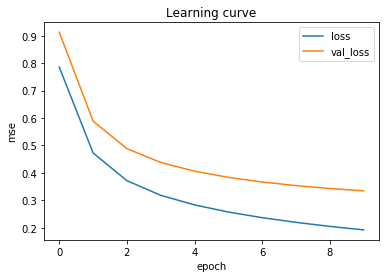

In [43]:
cls1.plot_learning_curve()

### 環境②
- バッチサイズ：10
- エポック数：10
- 隠れ層の数：100
- 初期化方法：Simple
- 活性化関数：Relu
- 最適化方法：SGD

### 考察
- 学習データに対してはエポック数毎にロスが低下しているが、検証データに対しては2エポック以降は学習を行ってもロスの低下が少なくなっており、8epoch頃では学習曲線がほぼ水平となっており、学習出来ていないように見えている。環境①ではロスが低下している為、活性化関数をTanhからReluに変更したことが影響を与えている可能性あり。

In [44]:
cls2 = ScratchConv1DNeuralNetrowkClassifier(lr=0.01,\
                                            sigma=0.1,\
                                            batch_size=10,\
                                            n_epochs=10,\
                                            conv_params=conv_params,\
                                            hidden_size=100,\
                                            n_output=10,\
                                            initializer='Sim',\
                                            activater='Relu',\
                                            optimizer='SGD',\
                                            verbose=True)
cls2.fit(X_train, y_train, X_test, y_test)

1epoch目

学習用正解データとの誤差　：　0.5888

検証用正解データとの誤差　：　0.7334

------------------------------------------------
2epoch目

学習用正解データとの誤差　：　0.3631

検証用正解データとの誤差　：　0.5011

------------------------------------------------
3epoch目

学習用正解データとの誤差　：　0.2841

検証用正解データとの誤差　：　0.4359

------------------------------------------------
4epoch目

学習用正解データとの誤差　：　0.2352

検証用正解データとの誤差　：　0.4014

------------------------------------------------
5epoch目

学習用正解データとの誤差　：　0.1993

検証用正解データとの誤差　：　0.3802

------------------------------------------------
6epoch目

学習用正解データとの誤差　：　0.1721

検証用正解データとの誤差　：　0.3678

------------------------------------------------
7epoch目

学習用正解データとの誤差　：　0.1492

検証用正解データとの誤差　：　0.3592

------------------------------------------------
8epoch目

学習用正解データとの誤差　：　0.1316

検証用正解データとの誤差　：　0.3566

------------------------------------------------
9epoch目

学習用正解データとの誤差　：　0.1160

検証用正解データとの誤差　：　0.3533

------------------------------------------------
10epoch目

学習用正解データとの誤差　：　0.1029

検証用正解データとの誤差　：　0.3537

--------

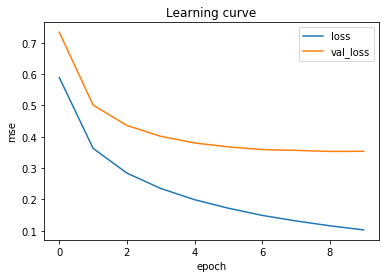

In [45]:
cls2.plot_learning_curve()

### 環境③
- バッチサイズ：10
- エポック数：10
- 隠れ層の数：100
- 初期化方法：Simple
- 活性化関数：Tanh
- 最適化方法：AdaGrad

### 考察
- 学習データに対してはエポック数毎にロスが低下しているが、検証データに対しては環境②と同様に2エポック以降は学習を行ってもロスの低下が少なくなっているが、環境②のように学習曲線が水平にはなっていない事から、学習自体は出来ていると思われる。環境①ではロスが低下している為、最適化方法をTanhからAdaGradに変更したことが影響を与えている可能性あり。

In [46]:
cls3 = ScratchConv1DNeuralNetrowkClassifier(lr=0.01,\
                                            sigma=0.1,\
                                            batch_size=10,\
                                            n_epochs=10,\
                                            conv_params=conv_params,\
                                            hidden_size=100,\
                                            n_output=10,\
                                            initializer='Sim',\
                                            activater='Tanh',\
                                            optimizer='AdaGrad',\
                                            verbose=True)
cls3.fit(X_train, y_train, X_test, y_test)

1epoch目

学習用正解データとの誤差　：　0.3923

検証用正解データとの誤差　：　0.5134

------------------------------------------------
2epoch目

学習用正解データとの誤差　：　0.2974

検証用正解データとの誤差　：　0.4192

------------------------------------------------
3epoch目

学習用正解データとの誤差　：　0.2551

検証用正解データとの誤差　：　0.3794

------------------------------------------------
4epoch目

学習用正解データとの誤差　：　0.2282

検証用正解データとの誤差　：　0.3557

------------------------------------------------
5epoch目

学習用正解データとの誤差　：　0.2085

検証用正解データとの誤差　：　0.3397

------------------------------------------------
6epoch目

学習用正解データとの誤差　：　0.1930

検証用正解データとの誤差　：　0.3279

------------------------------------------------
7epoch目

学習用正解データとの誤差　：　0.1802

検証用正解データとの誤差　：　0.3189

------------------------------------------------
8epoch目

学習用正解データとの誤差　：　0.1693

検証用正解データとの誤差　：　0.3116

------------------------------------------------
9epoch目

学習用正解データとの誤差　：　0.1599

検証用正解データとの誤差　：　0.3057

------------------------------------------------
10epoch目

学習用正解データとの誤差　：　0.1516

検証用正解データとの誤差　：　0.3007

--------

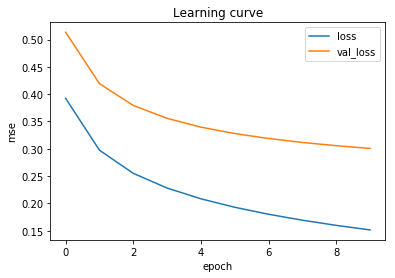

In [47]:
cls3.plot_learning_curve()